In [2]:
from geoparser import Geoparser
from tqdm.autonotebook import tqdm, trange
import pandas as pd

import warnings

# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

C:\Users\joost\anaconda3\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


### Load Geoparser

To use Geoparser, instantiate an object of the Geoparser class with optional specifications for the spaCy model, transformer model, and gazetteer. By default, the library uses an accuracy-optimised configuration:

In [5]:
geo = Geoparser(spacy_model='en_core_web_trf', transformer_model='dguzh/geo-all-distilroberta-v1', gazetteer='geonames')

Geoparser is optimised for parsing large collections of texts at once. To perform parsing, supply a list of strings to the parse method. This method processes the input and returns a list of GeoDoc objects, each containing identified and resolved toponyms:

```python
docs = geo.parse(["Sample text 1", "Sample text 2", "Sample text 3"])
```

Modify your code above to run your own three strings for geodata.


In [7]:
docs = geo.parse (["The text goes here. New York","There are also locations in Harrisonburg"])

Toponym Recognition...


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Toponym Resolution...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

We can get the result by cycling through every individual instances of the toponyms in the collectino stored in docs.

In [9]:
for doc in docs:
    for toponym in doc.toponyms:
        print(toponym)

New York
Harrisonburg


The toponym variable actually stores a lot of other information as well. The data structure looks like this:

```python
{
'geonameid': 2867714,
'name': 'Munich',
'admin2_geonameid': 2861322,
'admin2_name': 'Upper Bavaria',
'admin1_geonameid': 2951839,
'admin1_name': 'Bavaria',
'country_geonameid': 2921044,
'country_name': 'Germany',
'feature_name': 'seat of a first-order administrative division',
'latitude': 48.13743,
'longitude': 11.57549,
'elevation': None,
'population': 1260391
}
```

Much like a list or a dataframe we can navigate to these individual values by accessing the `.location` value in the toponym, and then going to the individual `key`.

In [12]:
for doc in docs:
    for toponym in doc.toponyms:
        if toponym.location:
            # If location is resolved
            place_name = toponym
            latitude = toponym.location['latitude']
            longitude = toponym.location['longitude']
            print(f"Place: {place_name}, Latitude: {latitude}, Longitude: {longitude}")
        else:
            # If no location is resolved
            print(f"No location found for toponym: {toponym}")


Place: New York, Latitude: 40.71427, Longitude: -74.00597
Place: Harrisonburg, Latitude: 38.44957, Longitude: -78.86892


### Load in sentiment data

We can load in the data from last lesson and start there.

In [15]:
df_virginia_toponyms_sentiment = pd.read_pickle('df_virginia_toponym_sentiment_full.pickle')

As the toponym extraction process is very time intensive. We will run it on a sample, just to show you how it works. The full results will be imported below.

In [18]:
df_virginia_sample = df_virginia_toponyms_sentiment.head(300).copy()
df_virginia_sample.sample(5)

,text_id,title,subjects,last_name,first_name,birth,death,cleaned_sentences,toponyms,nltk_sentiment,roberta_neg,roberta_neu,roberta_pos
97,2674,The Complete Writings of Charles Dudley Warner...,Autobiographies; Virginia -- Description and t...,Warner,Charles Dudley,1829,1900,Roan Station is on the Doe River which flows d...,[Roan],0.0000,0.038174,0.904343,0.057483
35,2674,The Complete Writings of Charles Dudley Warner...,Autobiographies; Virginia -- Description and t...,Warner,Charles Dudley,1829,1900,"But by and by sleep came, and John forgot his...",[Madagascar],0.0000,0.081290,0.552303,0.366407
275,2898,Pioneers of the Old South: A Chronicle of Engl...,"Southern States -- History -- Colonial period,...",Johnston,Mary,1870,1936,He had known seafights and shipwrecks and had...,[Italy],0.3400,0.036820,0.792765,0.170415
19,2674,The Complete Writings of Charles Dudley Warner...,Autobiographies; Virginia -- Description and t...,Warner,Charles Dudley,1829,1900,The history of Greece and Rome was stuff comp...,"[Greece, Rome]",0.0000,0.355574,0.594465,0.049961
138,2674,The Complete Writings of Charles Dudley Warner...,Autobiographies; Virginia -- Description and t...,Warner,Charles Dudley,1829,1900,And the Mitchell County people laughed again ...,[Mitchell County],0.0516,0.754773,0.230276,0.014951


Since the `geo.parse` function is expecting a list of strings and outputs a complicated piece of data, this logic has been abstracted out into a function to make things a bit simpler. The function goes through and looks at the strings in `cleaned_sentences` and tries to establish a toponym. It also includes a `feature_filter` for only Administrative areas [`A`] (Countries, States, Counties) and Population centers [`P`] because otherwise the process will take very long and also include geographic features like streams, rivers, gulley's etc.

In [26]:
def geoparse_column(df):
    sentences = df['cleaned_sentences'].tolist()  # Convert column to list
    docs = geo.parse(sentences, feature_filter=['A', 'P'])  # Run geo.parse on the entire list

    # Initialize lists to store the extracted fields
    places, latitudes, longitudes, feature_names = [], [], [], []

    # Iterate through the results and extract toponyms and their locations
    for doc in docs:
        doc_places = []
        doc_latitudes = []
        doc_longitudes = []
        doc_feature_names = []

        for toponym in doc.toponyms:
            if toponym.location:
                doc_places.append(toponym.location.get('name'))
                doc_latitudes.append(toponym.location.get('latitude'))
                doc_longitudes.append(toponym.location.get('longitude'))
                doc_feature_names.append(toponym.location.get('feature_name'))
            else:
                doc_places.append(None)
                doc_latitudes.append(None)
                doc_longitudes.append(None)
                doc_feature_names.append(None)

        # Append the extracted data for the document
        places.append(doc_places)
        latitudes.append(doc_latitudes)
        longitudes.append(doc_longitudes)
        feature_names.append(doc_feature_names)

    # Assign the extracted data to the DataFrame as new columns
    df['place'] = places
    df['latitude'] = latitudes
    df['longitude'] = longitudes
    df['feature_name'] = feature_names

    return df


In [28]:
geoparse_results_sample = geoparse_column(df_virginia_sample)

Toponym Recognition...


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

Toponym Resolution...


Batches:   0%|          | 0/505 [00:00<?, ?it/s]

Batches:   0%|          | 0/57 [00:00<?, ?it/s]

In [29]:
geoparse_results_sample.sample(5, random_state =10)

,text_id,title,subjects,last_name,first_name,birth,death,cleaned_sentences,toponyms,nltk_sentiment,roberta_neg,roberta_neu,roberta_pos,place,latitude,longitude,feature_name
24,2674,The Complete Writings of Charles Dudley Warner...,Autobiographies; Virginia -- Description and t...,Warner,Charles Dudley,1829,1900,"When supper came, he never went near Cynthia, ...",[Cynthia],0.4215,0.263413,0.641921,0.094665,[],[],[],[]
65,2674,The Complete Writings of Charles Dudley Warner...,Autobiographies; Virginia -- Description and t...,Warner,Charles Dudley,1829,1900,"Yes, they'd got a Republican member of Congre...",[he'd],-0.1280,0.252675,0.648327,0.098998,[],[],[],[]
113,2674,The Complete Writings of Charles Dudley Warner...,Autobiographies; Virginia -- Description and t...,Warner,Charles Dudley,1829,1900,Grandfather loomed up much more loftily than t...,[South Carolina],-0.7003,0.021178,0.523528,0.455294,"[None, South Carolina]","[None, 34.00043]","[None, -81.00009]","[None, first-order administrative division]"
261,2898,Pioneers of the Old South: A Chronicle of Engl...,"Southern States -- History -- Colonial period,...",Johnston,Mary,1870,1936,Ten years' time from this first Virginia voyag...,[Virginia],-0.2500,0.285936,0.682786,0.031278,"[Virginia, Java]","[37.54812, 36.83597]","[-77.44675, -79.2278]","[first-order administrative division, populate..."
188,2674,The Complete Writings of Charles Dudley Warner...,Autobiographies; Virginia -- Description and t...,Warner,Charles Dudley,1829,1900,The stream that originates in Hickory Nut Gap ...,[Rutherford County],0.0258,0.021638,0.932450,0.045912,"[None, East Windsor, Rutherford County, Columb...","[None, 41.91232, 35.8427, 35.61507, 39.46883, ...","[None, -72.54509, -86.41674, -87.03528, -74.63...","[None, populated place, second-order administr..."


Since the is still sorted into individual dictionary entries, we are going to extract it into the columns we need: `place`, `latitude`, `longitude`, and `feature_name`.

There are several interesting things of note in the data. First, for some of the sentences the tokenizer did not find a toponym which is indicated by empty lists `[]`. This because this is a more accurate tokenizer and will likely have fewer false positives. We will have to remember to remove these. Likewise, right now the parsing has been set to include Administrative areas like countries and states (i.e. The US and Virginia) and population centers (Richmond, Harrisonburg). We will have to think of how to deal with these down the road.

**We can run the geoparser for all the data and expect to wait at least an hour!**

In [34]:
# Run the geoparser over the entire 'cleaned_sentences' column
#geoparse_results = geoparse_column(df_virginia_toponyms_sentiment)

Toponym Recognition...


Batches:   0%|          | 0/45972 [00:00<?, ?it/s]

Toponym Resolution...


Batches:   0%|          | 0/7561 [00:00<?, ?it/s]

Batches:   0%|          | 0/9051 [00:00<?, ?it/s]

In [ ]:
# Display the updated DataFrame with new columns
#geoparse_results.sample(10)

In [48]:
#geoparse_results.to_pickle('df_virginia_geoparsed_complete.pickle')

### Load in geoparsed file

Because the geoparsing process takes so long, we can simply load in the file that has already been processed.

In [52]:
df_virginia_all = pd.read_pickle('df_virginia_geoparsed_complete.pickle')

Note that since the toponym tagger was especially trained for geographic locations it is more accurate. Hence, it also ignores false positives.

In [91]:
df_virginia_all[['toponyms','place']].sample(7, random_state = 19)

,toponyms,place
1199,[Jonesboro],[Jonesborough]
21900,[Smith],[]
14278,[England],[England]
6631,[Virginia],[Virginia]
42860,[Williamsburg],[Williamsburg]
28682,[Virginia],[Virginia]
27992,[Virginia],[Virginia]


Calculate the number of false positives in the original toponyms.

In [62]:
empty_percent = (df_virginia_all['place'].str.len() == 0).mean() * 100
print(f"The number of missing values is {empty_percent:.0f}%")

The number of missing values is 18%


#### Remove false positives

In [121]:
df_virginia_cleaned = df_virginia_all[df_virginia_all['place'].str.len() != 0].copy()

In [123]:
df_virginia_cleaned[['cleaned_sentences','place','latitude','longitude']].sample(5, random_state= 15)

,cleaned_sentences,place,latitude,longitude
20603,"Lewis Burwell had 7,000 acres in the Isle of ...","[None, King County, Gloucester, York, James Ci...","[None, 47.49084, 42.61405, 47.70899, 37.31332]","[None, -121.83583, -70.66313, -122.15374, -76...."
34520,CHAPTER X Second Manassas and Maryland camp...,"[Manassas, Maryland, None, Winchester, None, F...","[38.75095, 39.00039, None, 39.18566, None, 38....","[-77.47527, -76.74997, None, -78.16333, None, ..."
18492,"Major McDowell, with a battalion of North Caro...","[North Carolina, Georgia]","[35.50069, 32.75042]","[-80.00032, -83.50018]"
34625,"Company F, a sturdy lot of men, came from the ...","[Alleghany, Montgomery County, Christiansburg]","[37.74734, 32.17336, 37.12985]","[-80.24035, -82.53482, -80.40894]"
4604,Oronoco is thought to have originated in the v...,"[Oronoco, Orinoco, Venezuela]","[37.73736, 10.20675, 21.73748]","[-79.25364, -63.89292, -78.79336]"


In [125]:
df_virginia_long = df_virginia_cleaned.explode(['place', 'latitude', 'longitude', 'feature_name'])

In [127]:
df_virginia_long[['place', 'latitude', 'longitude', 'feature_name']].sample(5, random_state = 7)

,place,latitude,longitude,feature_name
19151,Carolina,34.57461,-79.4381,populated place
42318,Leesburg,39.11566,-77.5636,seat of a second-order administrative division
17806,None,None,None,None
8329,Buffalo Gap,43.49165,-103.31297,populated place
22426,West Virginia,38.50038,-80.50009,first-order administrative division


#### Critical Question

From a cartographic perspective, what is the difference between the types of features recovered?

In [129]:
df_virginia_long.shape

(72408, 17)

We can remove all of the `None` values with `.notna()`. That is, if the value is not `None` return true.

In [136]:
df_virginia_long = df_virginia_long[df_virginia_long.place.notna()]
df_virginia_long.shape

(61679, 17)

In [138]:
df_virginia_long = df_virginia_long.reset_index(drop=True)

In [142]:
df_virginia_long.sample(3, random_state=25)

,text_id,title,subjects,last_name,first_name,birth,death,cleaned_sentences,toponyms,nltk_sentiment,roberta_neg,roberta_neu,roberta_pos,place,latitude,longitude,feature_name
42609,45741,Smithsonian Institution - United States Nation...,Archaeology; Excavations (Archaeology) -- Virg...,Noël Hume,Ivor,<NA>,<NA>,"LESTER J. CAPPON and STELLA F. DUFF, Virginia...","[Williamsburg, Va., the Virginia Gazette, Will...",0.0,0.037052,0.916798,0.046150,Williamsburg,37.2707,-76.70746,seat of a second-order administrative division
21056,32573,History of the Colony and Ancient Dominion of ...,"Virginia -- History -- Colonial period, ca. 16...",Campbell,Charles,1807,1876,A proclamation was also issued against Romish...,"[Maryland, Virginia]",0.0,0.506466,0.484640,0.008895,Maryland,39.00039,-76.74997,first-order administrative division
5130,26632,The Bounty of the Chesapeake: Fishing in Colon...,Fishing -- Virginia; Fisheries -- Virginia; Ch...,Wharton,James,<NA>,<NA>,"A Virginian born in 1792, Col. T. J. Randolph ...",[Charlottesville],0.0,0.068261,0.901379,0.030360,Charlottesville,38.02931,-78.47668,seat of a second-order administrative division


In [ ]:
#df_virginia_long.to_pickle('df_virginia_long.pickle')

We now have a list of every place, latitude, longitude, and type of place it is. This is coupled with the sentiment data. We now need to consolidate this into singular points. We are going to do this by using the `.groupby()` method, which makes the calculation by group. In this case our group is going to be `place`, meaning that for every place it will count the number of times it appears and also the average sentiment score.

In [147]:
df_geolocations_sentiments = df_virginia_long.groupby('place').agg(
    location_count=('place', 'size'),  # Count occurrences of each location
    latitude=('latitude', 'first'),    # Take the first latitude (you can also use 'mean')
    longitude=('longitude', 'first'),  # Take the first longitude (or 'mean')
    location=('feature_name','first'),
    avg_roberta_pos=('roberta_pos', 'mean'),  # Average of roberta_pos
    avg_roberta_neu=('roberta_neu', 'mean'),  # Average of roberta_neu
    avg_roberta_neg=('roberta_neg', 'mean')   # Average of roberta_neg
).reset_index()



In [149]:
df_geolocations_sentiments.sample(5, random_state=5)

,place,location_count,latitude,longitude,location,avg_roberta_pos,avg_roberta_neu,avg_roberta_neg
3929,Township of Duke,1,35.30272,-78.67037,third-order administrative division,0.088593,0.862536,0.048871
3026,Poiana lui Alexa,1,46.61883,27.61746,populated place,0.118878,0.865413,0.015709
857,Columbia,14,35.61507,-87.03528,seat of a second-order administrative division,0.094388,0.850249,0.055363
1590,Guinea,4,38.14374,-77.43776,populated place,0.060849,0.735438,0.203713
1961,Kingdom of Spain,252,40.0,-4.0,independent political entity,0.110769,0.656422,0.232809


In [151]:
df_geolocations_sentiments.sort_values(by='location_count', ascending=False).head(10)

,place,location_count,latitude,longitude,location,avg_roberta_pos,avg_roberta_neu,avg_roberta_neg
4060,Virginia,11532,37.54812,-77.44675,first-order administrative division,0.131104,0.698045,0.170851
1202,England,3809,52.16045,-0.70312,first-order administrative division,0.121552,0.676576,0.201872
4118,Washington,1696,47.50012,-120.50147,first-order administrative division,0.139701,0.722544,0.137755
4000,United States,1551,39.76,-98.5,independent political entity,0.148619,0.660084,0.191296
3242,Richmond,1423,37.55376,-77.46026,seat of a first-order administrative division,0.142591,0.714719,0.142690
2174,London,1283,51.50853,-0.12574,capital of a political entity,0.122501,0.737307,0.140192
2321,Maryland,1213,39.00039,-76.74997,first-order administrative division,0.106919,0.730720,0.162362
4248,Williamsburg,1049,37.2707,-76.70746,seat of a second-order administrative division,0.134095,0.747991,0.117914
1864,Jamestown,805,48.12815,-123.08712,populated place,0.119829,0.738668,0.141503
2660,New York,636,43.00035,-75.4999,first-order administrative division,0.119489,0.745374,0.135137


In [155]:
# Calculate the compound score and add it as a new column 'roberta_compound'
df_geolocations_sentiments['avg_roberta_compound'] = (
    df_geolocations_sentiments['avg_roberta_pos'] - df_geolocations_sentiments['avg_roberta_neg']
) * (1 - df_geolocations_sentiments['avg_roberta_neu'])


In [159]:
# Sort the DataFrame by 'roberta_compound' in ascending order and display the top 10 negative scores
top_10_negative = df_geolocations_sentiments.sort_values(by='avg_roberta_compound').head(10)
top_10_negative

,place,location_count,latitude,longitude,location,avg_roberta_pos,avg_roberta_neu,avg_roberta_neg,avg_roberta_compound
1738,Hilton,1,44.09029,-77.77406,populated place,0.003649,0.067961,0.928390,-0.861894
3503,Shahārat al Ghīs,1,16.18411,43.70228,seat of a second-order administrative division,0.005036,0.093997,0.900967,-0.811717
3046,Popham,1,51.19112,-1.20064,populated place,0.008168,0.111782,0.880050,-0.774421
3153,Rail,1,29.46656,80.95513,populated locality,0.006261,0.118392,0.875347,-0.766193
99,Appalachia,1,36.90676,-82.78183,populated place,0.006158,0.123105,0.870737,-0.758144
3788,Tadmur,1,34.5624,38.28402,seat of a second-order administrative division,0.006489,0.135395,0.858116,-0.736321
1477,Gobolka Woqooyi Galbeed,1,10.0,44.5,first-order administrative division,0.016224,0.135316,0.848460,-0.719621
198,Bank,1,51.51307,-0.08948,populated place,0.016224,0.135316,0.848460,-0.719621
179,Bahía Honda,1,9.31606,-82.1565,populated place,0.008695,0.164638,0.826667,-0.683302
3022,Pocatalico,1,38.49037,-81.64735,populated place,0.007345,0.189897,0.802758,-0.644367


We can already tell there might be some challenges here. The values with the strongest scores tend to be low in count. Also, these are different types of features. We will have to filter out certain places.

In [212]:
#df_geolocations_sentiments.to_pickle('df_geolocations_sentiments.pickle')

In [214]:
df_geolocations_sentiments = pd.read_pickle('df_geolocations_sentiments.pickle')

## Mapping Sentiment

In the early days of digital mapping, getting map on the web was truly a lot of labor. You would have to map the data in a local piece of software, then export it to a format available for web viewing, using JavaScript to make it interactive, and then create your own custom webpage. Now we can do it with only a few lines of code using `plotly` which is a powerful visualization library that also has access to `mapbox` a very powerful piece of mapping software.

Below is the basic stub from the instructions to create a [map](https://plotly.com/python/tile-scatter-maps/). 

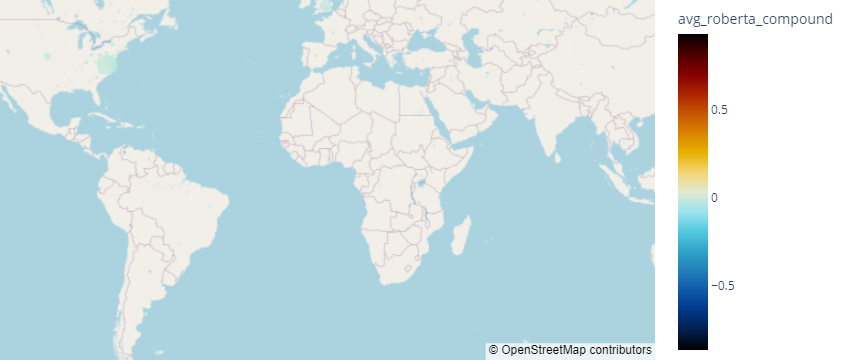

In [173]:
import plotly.express as px

# Create the map using plotly.express 
fig = px.scatter_mapbox(
    df_geolocations_sentiments,  #put your dataframe here
    lat="latitude",               # Latitude column
    lon="longitude",              # Longitude column
    size="location_count",        # Bubble size based on location count
    color="avg_roberta_compound",      # Color based on sentiment score
    color_continuous_scale=px.colors.cyclical.IceFire,  # Use IceFire scale (blue to red)
    size_max=15,                  # Maximum size of the bubbles
    center={"lat": 0.0, "lon": 0.0},
    zoom=1                        # Adjust zoom level for better visibility
)

# Update the layout to use the default map style (which doesn't need a token)
fig.update_layout(
    mapbox_style="open-street-map",  # No token needed for this style
    margin={"r":0,"t":0,"l":0,"b":0}  # Remove margins for a cleaner view
)

fig.show()

What are some issue with this map? How can we make it better?

## Adjust the position and the zoom

Look at the comments next to each variable in the plotly function, what does each thing do? 
- If I wanted to get a closer zoom how would I fix it?
- If I want to set a different center what should I choose?
- How would I change the size of the bubbles?
- How can I get a different mapbox style?

Take some time to mess around with your map.


[Read the full documentation](https://plotly.github.io/plotly.py-docs/generated/plotly.express.scatter_mapbox.html)

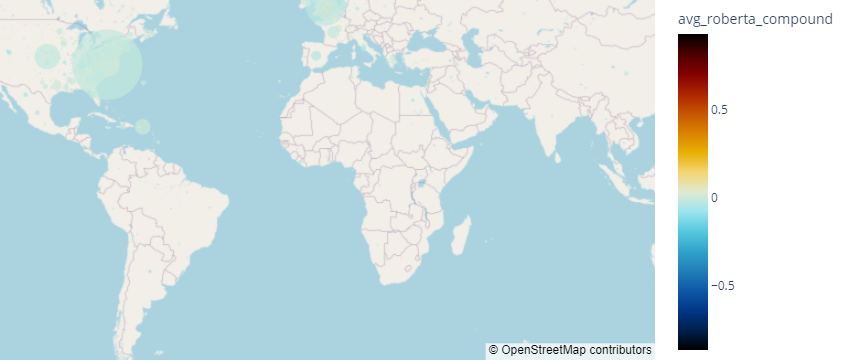

In [182]:
# Create the map using plotly.express 
fig = px.scatter_mapbox(
    df_geolocations_sentiments,  #put your dataframe here
    lat="latitude",               # Latitude column
    lon="longitude",              # Longitude column
    size="location_count",        # Bubble size based on location count
    color="avg_roberta_compound",      # Color based on sentiment score
    color_continuous_scale=px.colors.cyclical.IceFire,  # Use IceFire scale (blue to red)
    size_max=50,                  # Maximum size of the bubbles
    center={"lat": 0.0, "lon": 0.0},
    zoom=1                        # Adjust zoom level for better visibility
)

# Update the layout to use the default map style (which doesn't need a token)
fig.update_layout(
    mapbox_style="open-street-map",  # No token needed for this style
    margin={"r":0,"t":0,"l":0,"b":0}  # Remove margins for a cleaner view
)

fig.show()

One major issue is simply the size of the bubbles. The data is very spread out. The lowest number is 1 and the highest number is 11000. We can make life a little easier by simply removing some of the lower numbers. We can do this randomly by simply removing every below a certain count or we can be a bit more thoughtful and only consider a certain percentage of values. We can actually get a nice summary of a column using the `.describe()` function.



In [185]:
df_geolocations_sentiments.location_count.describe()

count     4360.000000
mean        14.146560
std        193.799785
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max      11532.000000
Name: location_count, dtype: float64

It actually looks like a significant number of locations appear very few times. We will have to keep this in mind going forward. For now, let's set our count threshold to 100.

### Critical Question

Create a new dataframe that sets the minimum location count to 100.

In [188]:
df_geolocations_sentiments_small = df_geolocations_sentiments[df_geolocations_sentiments.location_count>99]

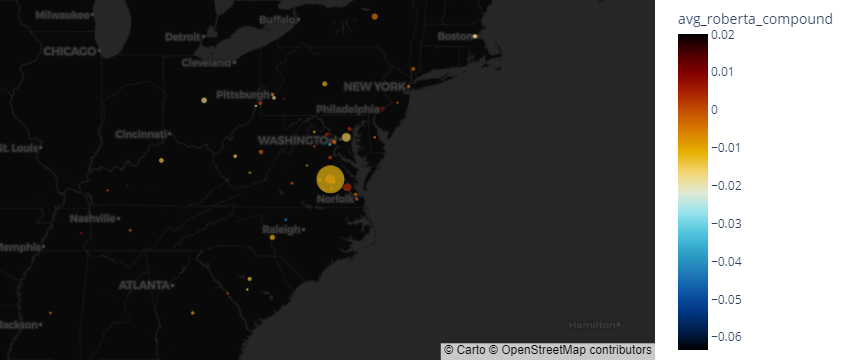

In [210]:
# Create the map using plotly.express 
fig = px.scatter_mapbox(
    df_geolocations_sentiments_small,  #put your dataframe here
    lat="latitude",               # Latitude column
    lon="longitude",              # Longitude column
    size="location_count",        # Bubble size based on location count
    color="avg_roberta_compound",      # Color based on sentiment score
    color_continuous_scale=px.colors.cyclical.IceFire,  # Use IceFire scale (blue to red)
    size_max=20,                  # Maximum size of the bubbles
    center={"lat": 37.5246322, "lon": -77.5758331},
    zoom=4                        # Adjust zoom level for better visibility
)

# Update the layout to use the default map style (which doesn't need a token)
fig.update_layout(
    mapbox_style="carto-darkmatter",  # No token needed for this style
    margin={"r":0,"t":0,"l":0,"b":0}  # Remove margins for a cleaner view
)



fig.show()

In [243]:
import mapclassify as mc #you may get an error. If so install mapclassify with pip install mapclassify

jenks_breaks = mc.NaturalBreaks(y=df_geolocations_sentiments_small['location_count'], k=5)

# Create a new column 'location_count_bucket' for the classified values
df_geolocations_sentiments_small.loc[:,'location_count_bucket'] = jenks_breaks.find_bin(df_geolocations_sentiments_small['location_count'])+1


C:\Users\joost\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



In [245]:
df_geolocations_sentiments_small.sample(5, random_state=4)

,place,location_count,latitude,longitude,location,avg_roberta_pos,avg_roberta_neu,avg_roberta_neg,avg_roberta_compound,location_count_bucket
4248,Williamsburg,1049,37.2707,-76.70746,seat of a second-order administrative division,0.134095,0.747991,0.117914,0.004078,3
1961,Kingdom of Spain,252,40.0,-4.0,independent political entity,0.110769,0.656422,0.232809,-0.041930,1
2321,Maryland,1213,39.00039,-76.74997,first-order administrative division,0.106919,0.730720,0.162362,-0.014930,3
1704,Henrico County,155,37.45771,-77.29646,second-order administrative division,0.072984,0.814176,0.112840,-0.007406,1
1623,Hampton,189,37.02987,-76.34522,seat of a second-order administrative division,0.088644,0.803255,0.108101,-0.003828,1


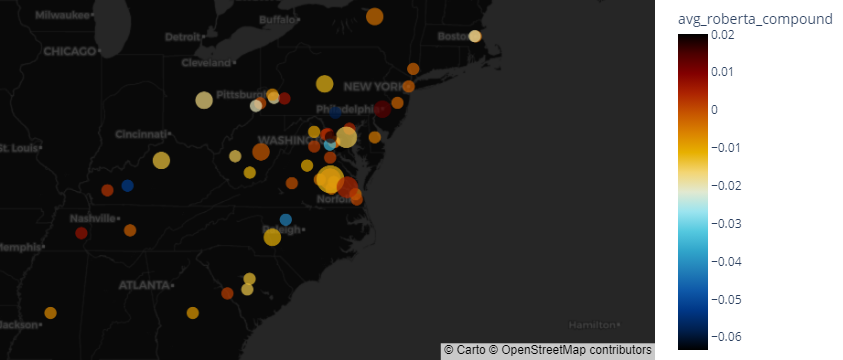

In [247]:
# Create the map using plotly.express 
fig = px.scatter_mapbox(
    df_geolocations_sentiments_small,  #put your dataframe here
    lat="latitude",               # Latitude column
    lon="longitude",              # Longitude column
    size="location_count_bucket",        # Bubble size based on location count
    color="avg_roberta_compound",      # Color based on sentiment score
    color_continuous_scale=px.colors.cyclical.IceFire,  # Use IceFire scale (blue to red)
    size_max=20,                  # Maximum size of the bubbles
    center={"lat": 37.5246322, "lon": -77.5758331},
    zoom=4                        # Adjust zoom level for better visibility
)

# Update the layout to use the default map style (which doesn't need a token)
fig.update_layout(
    mapbox_style="carto-darkmatter",  # No token needed for this style
    margin={"r":0,"t":0,"l":0,"b":0}  # Remove margins for a cleaner view
)



fig.show()


Now the markers need some labels and the colors need to be reversed and need a new midpoint.

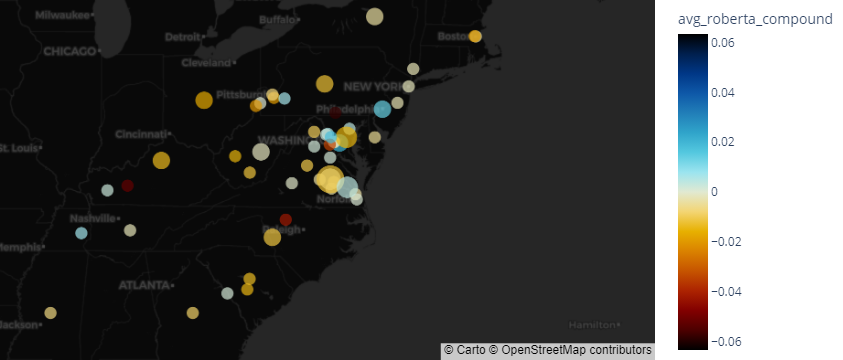

In [270]:
import plotly.express as px

fig = px.scatter_mapbox(
    df_geolocations_sentiments_small,  # DataFrame
    lat="latitude",                   # Latitude column
    lon="longitude",                  # Longitude column
    size="location_count_bucket",     # Bubble size based on location count bucket
    color="avg_roberta_compound",     # Color based on sentiment score
    color_continuous_scale=px.colors.cyclical.IceFire[::-1],  # IceFire color scale
    color_continuous_midpoint=0,      # Set 0 as the center point
    size_max=20,                      # Maximum size of the bubbles
    center={"lat": 37.5246322, "lon": -77.5758331},
    zoom=4,                           # Zoom level
    hover_name="place",               # Show place name
    hover_data={
            "avg_roberta_compound": ':.2f',   # Rounded sentiment score to 2 decimals
        "longitude": False,
        "latitude": False,
        "location_count_bucket": False
    }
)

# Update the layout to use the default map style
fig.update_layout(
    mapbox_style="carto-darkmatter",  # No token needed
    margin={"r": 0, "t": 0, "l": 0, "b": 0}  # Remove margins for cleaner view
)

# Show the plot
fig.show()


How else can this map be improved?